In [4]:
# import numpy as np
# import scipy.optimize as opt
# import tensorflow as tf
# from tensorflow.examples.tutorials.mnist import input_data
# import time

import MPO_hyperparameter_v2
import MPO_tt_v2
import MPO_inference_v2
import MPO_train_v2 as MPO

# import activation_functions as act
# import contractions as con
from neural_networks import *

# Pre-processing

## 1. Train

In [5]:
D = 4
threshold = 90

In [6]:
# List of layer 1 weights (0-3), layer 1 bias (4), layer 2 weights (5-8), layer 2 bias (9)
weights = MPO.main(r_1=D, r_2=D)

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Accuracy at step 0: 0.1863
Accuracy at step 1: 0.2536
Accuracy at step 2: 0.2831
Accuracy at step 3: 0.2917
Accuracy at step 4: 0.3265
Accuracy at step 5: 0.3895
Accuracy at step 6: 0.4222
Accuracy at step 7: 0.4437
Guessing
After 10 trainning step(s

## 2. Open weights matrices into correct MPO

In [7]:
sigma = [4, 7, 7, 4]
sigma_prime = [4, 4, 4, 4]
MPO_0, bias_0 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=0)

In [8]:
sigma = [4, 4, 4, 4]
sigma_prime = [1, 10, 1, 1]
MPO_1, bias_1 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=1)

## 3. Check that MPO is correct based on accuracy from model

In [9]:
acc, t = FC2(MPO_0, bias_0, MPO_1, bias_1)
print(acc, "%", t, "s")

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
58.74 % 0.0029942989349365234 s


## 4. Close legs to use for compression algorithm

In [10]:
MPS_0 = close_legs(MPO_0)
MPS_1 = close_legs(MPO_1)

## 5. Compress MPS layers

In [11]:
compressed_MPS_0, dist, sim = compress_layer(MPS_0, phys_dim=[16, 28, 28, 16], threshold=1e-8, plot=0)

Sim: 45.69605644748508 Dist: 21.436864813789875 BondDim: 1
Sim: 178.4403508720266 Dist: 18.077468811206977 BondDim: 2
Sim: 360.2774786067217 Dist: 12.039840151989795 BondDim: 3


In [12]:
compressed_MPS_0.append(MPS_0)

In [14]:
compressed_MPS_1, dist, sim = compress_layer(MPS_1, phys_dim=[4, 40, 4, 4], threshold=1e-8, plot=0)

Sim: 13.554116511840352 Dist: 6.074632497313518 BondDim: 1
Sim: 36.53650747284492 Dist: 3.730786648471457 BondDim: 2
Sim: 47.38375159652044 Dist: 1.7525766438981636 BondDim: 3


In [15]:
compressed_MPS_1.append(MPS_1)

In [16]:
print("Orig:", calculate_params(MPS_0))
for i in range(len(compressed_MPS_0)):
    print(i+1, round(calculate_params(compressed_MPS_0[i])/calculate_params(MPS_0)*100, 2), "% of Orig")

Orig: 1024
1 8.59 % of Orig
2 28.12 % of Orig
3 58.59 % of Orig
4 100.0 % of Orig


In [17]:
print("Orig:", calculate_params(MPS_1))
for i in range(len(compressed_MPS_1)):
    print(i+1, round(calculate_params(compressed_MPS_1[i])/calculate_params(MPS_1)*100, 2), "% of Orig")

Orig: 736
1 7.07 % of Orig
2 26.09 % of Orig
3 57.07 % of Orig
4 100.0 % of Orig


# Accuracy Tests

## 1. Check accuracy for each compressed dimension

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


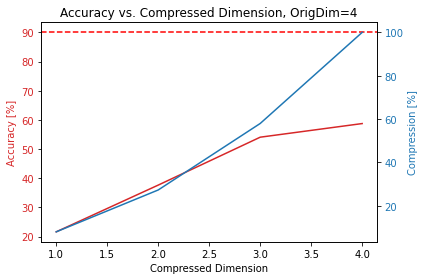

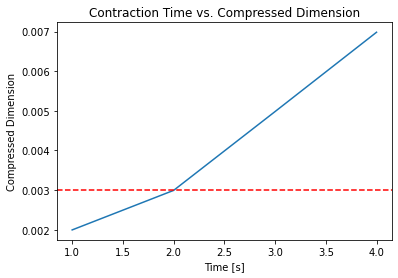

In [23]:
test_overall_accuracy_FC2(compressed_MPS_0, compressed_MPS_1, sigma_0=[4,7,7,4], sigma_1=[4,4,4,4], sigma_2=[1,10,1,1], threshold=90)

## 2. Check accuracy when compressing one layer at a time

In [ ]:
def test_accuracy_single_layer(compressed_MPS_0, compressed_MPS_1, sigma, sigma_prime, layer):
    ### Check changes in W1 for constant W0
    plt.figure()
    for W0_dim in range(1, len(compressed_MPS_0)+1):
        acc_compressed = []
        time_compressed = []
        MPS_0_test = compressed_MPS_0[W0_dim-1]
        for W1_dim in range(1, len(compressed_MPS_1)+1):
            MPS_1_test = compressed_MPS_1[W1_dim-1]

            dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
            dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
            MPO_0_test = open_legs(MPS_0_test, MPO_0, bond_dim=dim_0)
            MPO_1_test = open_legs(MPS_1_test, MPO_1, bond_dim=dim_1)

            acc, t = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
            acc_compressed.append(acc)
            time_compressed.append(t)

        acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
        plt.plot(range(1, len(compressed_MPS_0)+1), acc_compressed, label="W0_dim=%d" % W0_dim)
        plt.axhline(threshold, color='r', linestyle='--')
        plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
        plt.title('Accuracy vs. Compressed Dimension, OrigDim=%d' %(len(compressed_MPS_0)+1))
        plt.xlabel('Compressed Dimension W1')
        plt.ylabel('Accuracy [%]')

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t1

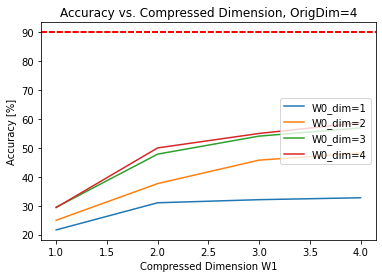

In [32]:
### Check changes in W1 for constant W0
plt.figure()
for W0_dim in range(1, len(compressed_MPS_0)+1):
    acc_compressed = []
    time_compressed = []
    MPS_0_test = compressed_MPS_0[W0_dim-1]
    for W1_dim in range(1, len(compressed_MPS_1)+1):
        MPS_1_test = compressed_MPS_1[W1_dim-1]

        dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
        dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
        MPO_0_test = open_legs(MPS_0_test, sigma=[4,7,7,4], sigma_prime=[4,4,4,4], bond_dim=dim_0)
        MPO_1_test = open_legs(MPS_1_test, sigma=[4,4,4,4], sigma_prime=[1,10,1,1], bond_dim=dim_1)

        acc, t = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
        #acc, t = FC2(MPS_0_test, bias_0, MPS_1_test, bias_1)
        acc_compressed.append(acc)
        time_compressed.append(t)

    acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
    plt.plot(range(1, len(compressed_MPS_0)+1), acc_compressed, label="W0_dim=%d" % W0_dim)
    plt.axhline(threshold, color='r', linestyle='--')
    plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
    plt.title('Accuracy vs. Compressed Dimension, OrigDim=%d' %(len(compressed_MPS_0)))
    plt.xlabel('Compressed Dimension W1')
    plt.ylabel('Accuracy [%]')

mages-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
E

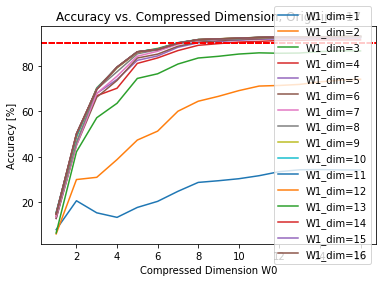

In [21]:
### Check changes in W0 for constant W1
plt.figure()
for W1_dim in range(1, len(compressed_MPS_1)+1):
    acc_compressed = []
    time_compressed = []
    MPS_1_test = compressed_MPS_1[W1_dim-1]
    for W0_dim in range(1, len(compressed_MPS_0)+1):
        MPS_0_test = compressed_MPS_0[W0_dim-1]

        dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
        dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
        MPO_0_test = open_legs(MPS_0_test, MPO_0, bond_dim=dim_0)
        MPO_1_test = open_legs(MPS_1_test, MPO_1, bond_dim=dim_1)

        acc, t = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
        acc_compressed.append(acc)
        time_compressed.append(t)


    acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
    plt.plot(range(1, len(compressed_MPS_0)+1), acc_compressed, label="W1_dim=%d" % W1_dim)
    plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
    plt.axhline(threshold, color='r', linestyle='--')
    plt.title('Accuracy vs. Compressed Dimension, OrigDim=%d' %(len(compressed_MPS_1)+1))
    plt.xlabel('Compressed Dimension W0')
    plt.ylabel('Accuracy [%]')

## 3. Heatmap of accuracy by layer dimension

In [39]:
acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
acc_matrix = []
for W0_dim in range(1, len(compressed_MPS_0)+1):
    acc_array = []
    MPS_0_test = compressed_MPS_0[W0_dim-1]
    for W1_dim in range(1, len(compressed_MPS_1)+1):
        MPS_1_test = compressed_MPS_1[W1_dim-1]

        dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
        dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
        MPO_0_test = open_legs(MPS_0_test, MPO_0, bond_dim=dim_0)
        MPO_1_test = open_legs(MPS_1_test, MPO_1, bond_dim=dim_1)

        acc, _ = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
        acc_array.append(acc)
    acc_matrix.append(acc_array)
# fig, ax = plt.subplots()
# im = ax.imshow(acc_matrix, cmap='inferno_r')

# # We want to show all ticks...
# ax.set_xticks(np.arange(len(compressed_MPS_0)+1))
# ax.set_yticks(np.arange(len(compressed_MPS_1)+1))
# # ... and label them with the respective list entries
# ax.set_xticklabels(np.arange(1, len(compressed_MPS_0)+1))
# ax.set_yticklabels(np.arange(1, len(compressed_MPS_1)+1))

# # Rotate the tick labels and set their alignment.
# # plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
# #          rotation_mode="anchor")

# plt.xlabel('W0 Dimension')
# plt.ylabel('W1 Dimension')
# plt.title('Loss vs. Compressed Dimensions, OrigDim=%d' % D)
# Loop over data dimensions and create text annotations.
# for i in range(len(compressed_MPS_0)):
#     for j in range(len(compressed_MPS_1)):
#         text = ax.text(j, i, np.round(acc_matrix[i][j], 2),
#                        ha="center", va="center", color="w")

mages-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
E

## 4. Compression ratio for layer dimensions

In [40]:
orig_params = calculate_params(MPS_0)+calculate_params(MPS_1)
params_matrix = []
compression_ratio_matrix = []
for i in range(len(compressed_MPS_0)):
    compression_ratio = []
    for j in range(len(compressed_MPS_1)):
        params = calculate_params(compressed_MPS_0[i]) + calculate_params(compressed_MPS_1[j])
        compression_ratio.append(round(params/orig_params*100, 2))
    compression_ratio_matrix.append(compression_ratio)

# fig, ax = plt.subplots()
# im = ax.imshow(compression_ratio_matrix, cmap='inferno_r')

# ax.set_xticks(np.arange(len(compressed_MPS_0)+1))
# ax.set_yticks(np.arange(len(compressed_MPS_1)+1))
# ax.set_xticklabels(np.arange(1, len(compressed_MPS_0)+1))
# ax.set_yticklabels(np.arange(1, len(compressed_MPS_1)+1))

# plt.xlabel('W0 Dimension')
# plt.ylabel('W1 Dimension')
# plt.title('Compression Ratio vs. Compressed Dimensions, OrigDim=%d' % D)

# # Loop over data dimensions and create text annotations.
# for i in range(len(compressed_MPS_0)):
#     for j in range(len(compressed_MPS_1)):
#         text = ax.text(j, i, np.round(compression_ratio_matrix[i][j], 2),
#                        ha="center", va="center", color="w")

## 5. Compression ratio for accuracy above threshold 

Best Compression: 4.42 %
W0_dim =  7
W1_dim =  9


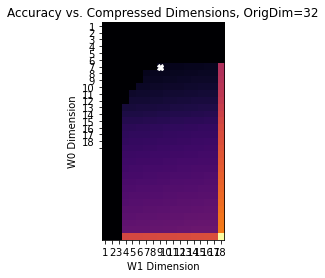

In [41]:
compression_ratio_plot = np.array(compression_ratio_matrix[:])
acc_matrix_plot = np.array(acc_matrix[:])
compression_ratio_plot[acc_matrix_plot < threshold] = 0

fig, ax = plt.subplots()
im = ax.imshow(compression_ratio_plot, cmap='inferno')
ax.set_xticks(np.arange(len(compressed_MPS_0)+1))
ax.set_yticks(np.arange(len(compressed_MPS_1)+1))
ax.set_xticklabels(np.arange(1, len(compressed_MPS_0)+1))
ax.set_yticklabels(np.arange(1, len(compressed_MPS_1)+1))

plt.xlabel('W1 Dimension')
plt.ylabel('W0 Dimension')
plt.title('Accuracy vs. Compressed Dimensions, OrigDim=%d' % D)
try:
    minval = np.min(compression_ratio_plot[np.nonzero(compression_ratio_plot)])
    ij = np.where(compression_ratio_plot == minval)
    plt.plot(ij[1], ij[0], 'wX')
    print("Best Compression:", minval, "%")
    print("W0_dim = ", ij[0][0]+1)
    print("W1_dim = ", ij[1][0]+1)
except:
    print("Layers cannot be compressed and still reach given threshold")


# Loop over data dimensions and create text annotations.
# for i in range(len(compressed_MPS_0)):
#     for j in range(len(compressed_MPS_1)):
#         text = ax.text(j, i, np.round(compression_ratio_matrix[i][j], 2),
#                        ha="center", va="center", color="w")

## 6. Dependence of accuracy on compression

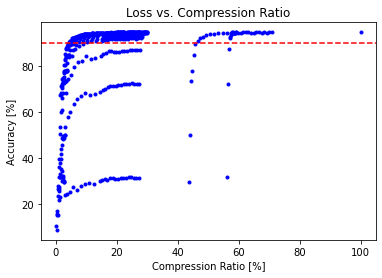

In [42]:
sorted_comp = np.array(compression_ratio_matrix[:])
sorted_acc = np.array(acc_matrix[:])
sorted_comp = np.reshape(sorted_comp, sorted_comp.size)
sorted_acc = np.reshape(sorted_acc, sorted_acc.size)
sorted_comp, sorted_acc = zip(*sorted(zip(sorted_comp, sorted_acc)))

plt.plot(sorted_comp, sorted_acc, 'b.')

plt.title("Loss vs. Compression Ratio")
plt.xlabel("Compression Ratio [%]")
plt.ylabel("Accuracy [%]")
plt.axhline(threshold, color='r', linestyle='--')

In [ ]:
def vector_to_left_canonical_MPS_NN(tensor, phys_dim):
    """ Decomposes a vector of length d^L (phys_dim^num_sites) into a
        left-canonical MPS. Final site will not be canonical due to
        original norm

    Args:
        tensor: Vector of length that can be described by d^L (Ex: 512 = 2^9)
        phys_dim: Physical dimension necessary on MPS at each site (d)
        num_sites: Number of sites necessary (L)

    Returns:
        A_tensors: Left canonical form of input MPS
    """

    A_tensors = []
    num_sites = len(phys_dim)
    for i in range(0, num_sites-1):
        # Remove one leg such that tensor has shape (d, d^(L-1)) with L sites
        if i == 0:
            reshaped_tensor = np.reshape(tensor, (phys_dim[i],
                                                  tensor.shape[0]//phys_dim[i]))
        else:
            reshaped_tensor = np.reshape(tensor, (A_tensors[-1].shape[1]*phys_dim[i],
                                                  tensor.shape[1]//phys_dim[i]))       
        #print("Reshape:", reshaped_tensor.shape)

        # SVD and save the rank for the next iteration of the loop
        U, S_vector, V = np.linalg.svd(reshaped_tensor, full_matrices=False)
        rank = len(S_vector)

        if i == 0:
            # No need to reshape since U is already a left-canonical matrix
            A_tensors.append(U)
        else:
            # Break apart first leg of U into a left bond dimension
            # and physical dimension
            U = np.reshape(U, (A_tensors[-1].shape[1], phys_dim[i], U.shape[1]))
            # Transpose so that we have the correct shape
            # (left bond, right bond, physical dimension)
            U = np.transpose(U, (0, 2, 1))
            A_tensors.append(U)

        # We recreate the tensor with the remaining legs
        tensor = np.diag(S_vector) @ V
    # Final A tensor is the remaining tensor after all other legs removed
    A_tensors.append(tensor)

    return A_tensors

In [ ]:
data = input_data.read_data_sets("./data/",validation_size=0,one_hot=True)
x_MPS = vector_to_left_canonical_MPS_NN(data.test.images[0], phys_dim=[4, 7, 7, 4])

# Proof that MPO structure is only used for storage

In [ ]:
def FC2_MPO(MPO_0, bias_0, MPO_1, bias_1):
    data = input_data.read_data_sets("./data/",validation_size=0,one_hot=True)
    

    start = time.time()

    end = time.time()

    total = 1000
    correct = 0
    for i in range(0, total):
        xW = []
        # Decompose input into an MPS
        x_MPS = vector_to_left_canonical_MPS_NN(data.test.images[i], phys_dim=[4, 7, 7, 4])
        # Contract into W0
        for i in range(len(x_MPS)):
            site = con.contract_vertical(x_MPS[i], MPO_0[i], 'up')
            xW.append(site)

        # Site-wise ReLU (DOES NOT WORK)
        # for site in xW:
        #     site = act.ReLU(site)

        # Contract xW0 into a matrix
        site = con.contract_horizontal(xW[0].T, xW[1], 'right')
        site = con.contract_horizontal(site, xW[2], 'right')
        xW_matrix = con.contract_horizontal(site, xW[3].T, 'right')

        # Full-Matrix ReLU (DOES NOT WORK)
        xW_matrix = act.ReLU(xW_matrix)

        temp = con.contract_horizontal(MPO_1[0], MPO_1[1], 'right')
        temp = con.contract_horizontal(temp, MPO_1[2], 'right')
        W_1 = con.contract_horizontal(temp, MPO_1[3], 'right')

        result = xW_matrix @ W_1 # + bias_1
        #print(result)
        #print(list(data.test.labels[i]).index(1))
        index = np.abs(result).argmin()
        if index == list(data.test.labels[i]).index(1):
            correct += 1

    return correct/total*100, end-start

In [ ]:
# 1. Decompose input vector into an MPS
FC2_MPO(MPO_0, bias_0, MPO_1, bias_1)